<a href="https://colab.research.google.com/github/ddy623/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_SalesMachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Using Machine Learning To Make Predictions**

The goal of this step is to help the retailer by using machine learning to make predictions about future sales based on the data provided.

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
## Numpy
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)
import missingno
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.experimental import enable_iterative_imputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor # NEW
from sklearn.tree import DecisionTreeRegressor
from sklearn import set_config
set_config(transform_output='pandas')

In [9]:
### LOAD DATASET FROM GOOGLE DRIVE OR URL
# load data
fpath = "/content/drive/MyDrive/CodingDojo/02-MachineLearning/Week05/Data/sales_predictions_2023.csv"
df = pd.read_csv(fpath)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [10]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

Ensure that there are no duplicates

In [11]:
# save the filter
duplicated_rows = df.duplicated()
duplicated_rows

0       False
1       False
2       False
3       False
4       False
        ...  
8518    False
8519    False
8520    False
8521    False
8522    False
Length: 8523, dtype: bool

In [12]:
# Remove duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

Drop Rows that contain NaN values

In [13]:
df = df.dropna()

Fix Inconsistencies

In [15]:
df['Item_Fat_Content'].value_counts()

Low Fat    2774
Regular    1575
LF          177
reg          71
low fat      53
Name: Item_Fat_Content, dtype: int64

In [16]:
#Correct inconsistency with Item_Fat_Content
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': "Low Fat", 'low fat': "Low Fat"})
df['Item_Fat_Content'].value_counts()

df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'reg': "Regular"})
df['Item_Fat_Content'].value_counts()

Low Fat    3004
Regular    1646
Name: Item_Fat_Content, dtype: int64

In [17]:
df['Item_Fat_Content'].value_counts()

Low Fat    3004
Regular    1646
Name: Item_Fat_Content, dtype: int64

Identify the features (X) and target (y): Assign the "Item_Outlet_Sales" column as your target and the rest of the relevant variables as your features matrix.

Perform Train-Test Split

In [18]:
# Define features (X) and target (y).
X = df.drop(columns=['Item_Outlet_Sales','Item_Identifier'])
y = df['Item_Outlet_Sales']
#Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
#Create a preprocessing object to prepare the dataset for Machine Learning
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [20]:
cat_cols = X_train.select_dtypes('object').columns
cat_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [21]:
#Null Values
X_train[cat_cols].isna().sum()

Item_Fat_Content        0
Item_Type               0
Outlet_Identifier       0
Outlet_Size             0
Outlet_Location_Type    0
Outlet_Type             0
dtype: int64

In [22]:
numeric_cols = X_train.select_dtypes('number').columns
numeric_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')

In [23]:
#Null Values
X_train[numeric_cols].isna().sum()

Item_Weight                  0
Item_Visibility              0
Item_MRP                     0
Outlet_Establishment_Year    0
dtype: int64

In [24]:
#Summary stats
X_train[numeric_cols].describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,3487.00,3487.00,3487.00,3487.00
mean,13.01,0.06,141.77,1999.21
std,4.67,0.04,62.33,7.41
min,4.56,0.00,31.96,1987.00
25%,8.90,0.03,94.73,1997.00
50%,12.85,0.05,142.48,1999.00
75%,17.10,0.09,186.62,2004.00
max,21.35,0.19,266.69,2009.00


Create Transformers for Preprocessing

In [25]:
#instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
num_pipe = make_pipeline (impute_median, scaler)
num_pipe

## Define the numeric tuple
num_tuple = ('Numeric', scaler, numeric_cols)



In [26]:
# Defining list of nominal features
ohe_cols = X_train.select_dtypes('object').columns
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Instantiate the pipeline
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe
## Define the categorical nominal tuple
ohe_tuple = ('Categorical', ohe_encoder, ohe_cols)

In [27]:
# Instantiate the make column transformer
preprocessor = col_transformer = ColumnTransformer([num_tuple,
                                      ohe_tuple],
                                       remainder='drop', verbose_feature_names_out=False)

In [28]:
# Fit the column transformer on the X_train
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('Numeric', StandardScaler(),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('Categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [29]:
# Transform the X_train and the X_test
X_train_proc = col_transformer.transform(X_train)
X_test_proc = col_transformer.transform(X_test)

**Build a Linear Regression Model to Predict Sales**

In [30]:
# Defining lists of types of features
num_cols = X_train.select_dtypes("number").columns
numeric_cols


Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')

In [31]:
# Null values
X_train[num_cols].isna().sum()


Item_Weight                  0
Item_Visibility              0
Item_MRP                     0
Outlet_Establishment_Year    0
dtype: int64

In [32]:
# Summary stats
X_train[num_cols].describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,3487.00,3487.00,3487.00,3487.00
mean,13.01,0.06,141.77,1999.21
std,4.67,0.04,62.33,7.41
min,4.56,0.00,31.96,1987.00
25%,8.90,0.03,94.73,1997.00
50%,12.85,0.05,142.48,1999.00
75%,17.10,0.09,186.62,2004.00
max,21.35,0.19,266.69,2009.00


In [33]:
# Fit the preprocessor on training data
preprocessor.fit(X_train)
# Transform the training and test data
X_train_tf = preprocessor.transform(X_train)
X_test_tf = preprocessor.transform(X_test)
X_train_tf.head()


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT018,Outlet_Identifier_OUT035,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2
1909,-1.618736,-0.801422,1.556160,-0.028286,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3715,1.656781,1.065099,0.317465,-0.028286,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3371,-0.494448,1.498777,-0.319787,1.321012,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
6743,0.587050,2.355606,-1.664345,1.321012,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
5207,-0.322222,-1.372834,-0.858776,-0.298146,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [34]:
## Create an instance of the model
lin_reg = LinearRegression()

## Create a model pipeline
lin_reg_pipe = make_pipeline(preprocessor, lin_reg)

## Fit the model
lin_reg_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numeric', StandardScaler(),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('Categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [35]:
evaluate_regression(lin_reg_pipe, X_train, y_train,
                    X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 808.107
- MSE = 1,197,351.816
- RMSE = 1,094.236
- R^2 = 0.468

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 786.245
- MSE = 1,145,234.159
- RMSE = 1,070.156
- R^2 = 0.484


From the data, we are able to compare the training data to the test data. Both are similar, as the training data is 0.468 and the test data is 0.484.

It appears that the data is underfit, as they are both are similar and mid range. This could be due to the data not having features that correlate well with the target.

Extracting Coefficients from linreg

In [36]:
## Display the model's coefficients
lin_reg.coef_

array([  -5.14124065,   -1.43963915, 1014.87051344,  -33.02184966,
         11.83759235,  -11.83759235,   28.67949677,  176.29325491,
         72.78353505,  -48.66592781, -100.34566709,  -54.64765854,
        -79.90374809,  -63.79181994,  -36.36772107, -105.32025077,
         38.73399173, -109.72234134,  391.35186146,  -15.87333773,
       -156.57886459,   63.37519705,    1.13668589,  -64.95427032,
         60.72046157,  -57.42352667,   60.52064952,    1.13668589,
         -4.4336208 ,    3.2969349 ,    3.09712285,   60.72046157,
        -63.81758442,   64.95427032,  -64.95427032])

In [37]:
## Display the model's intercept
lin_reg.intercept_

2290.0323389131468

In [38]:
## Saving the coefficients
coef_series = pd.Series(lin_reg.coef_, index=lin_reg.feature_names_in_)
coef_series

Item_Weight                          -5.141241
Item_Visibility                      -1.439639
Item_MRP                           1014.870513
Outlet_Establishment_Year           -33.021850
Item_Fat_Content_Low Fat             11.837592
Item_Fat_Content_Regular            -11.837592
Item_Type_Baking Goods               28.679497
Item_Type_Breads                    176.293255
Item_Type_Breakfast                  72.783535
Item_Type_Canned                    -48.665928
Item_Type_Dairy                    -100.345667
Item_Type_Frozen Foods              -54.647659
Item_Type_Fruits and Vegetables     -79.903748
Item_Type_Hard Drinks               -63.791820
Item_Type_Health and Hygiene        -36.367721
Item_Type_Household                -105.320251
Item_Type_Meat                       38.733992
Item_Type_Others                   -109.722341
Item_Type_Seafood                   391.351861
Item_Type_Snack Foods               -15.873338
Item_Type_Soft Drinks              -156.578865
Item_Type_Sta

In [39]:
## Add the Intercept
coef_series['intercept'] = lin_reg.intercept_
coef_series

Item_Weight                          -5.141241
Item_Visibility                      -1.439639
Item_MRP                           1014.870513
Outlet_Establishment_Year           -33.021850
Item_Fat_Content_Low Fat             11.837592
Item_Fat_Content_Regular            -11.837592
Item_Type_Baking Goods               28.679497
Item_Type_Breads                    176.293255
Item_Type_Breakfast                  72.783535
Item_Type_Canned                    -48.665928
Item_Type_Dairy                    -100.345667
Item_Type_Frozen Foods              -54.647659
Item_Type_Fruits and Vegetables     -79.903748
Item_Type_Hard Drinks               -63.791820
Item_Type_Health and Hygiene        -36.367721
Item_Type_Household                -105.320251
Item_Type_Meat                       38.733992
Item_Type_Others                   -109.722341
Item_Type_Seafood                   391.351861
Item_Type_Snack Foods               -15.873338
Item_Type_Soft Drinks              -156.578865
Item_Type_Sta

In [40]:
## formatting numbers to not use a , and to use thousands sep, and 4 digits floats
pd.set_option('display.float_format', lambda x: f"{x:,.4f}")

In [41]:
## show coefs again
coef_series

Item_Weight                          -5.1412
Item_Visibility                      -1.4396
Item_MRP                          1,014.8705
Outlet_Establishment_Year           -33.0218
Item_Fat_Content_Low Fat             11.8376
Item_Fat_Content_Regular            -11.8376
Item_Type_Baking Goods               28.6795
Item_Type_Breads                    176.2933
Item_Type_Breakfast                  72.7835
Item_Type_Canned                    -48.6659
Item_Type_Dairy                    -100.3457
Item_Type_Frozen Foods              -54.6477
Item_Type_Fruits and Vegetables     -79.9037
Item_Type_Hard Drinks               -63.7918
Item_Type_Health and Hygiene        -36.3677
Item_Type_Household                -105.3203
Item_Type_Meat                       38.7340
Item_Type_Others                   -109.7223
Item_Type_Seafood                   391.3519
Item_Type_Snack Foods               -15.8733
Item_Type_Soft Drinks              -156.5789
Item_Type_Starchy Foods              63.3752
Outlet_Ide

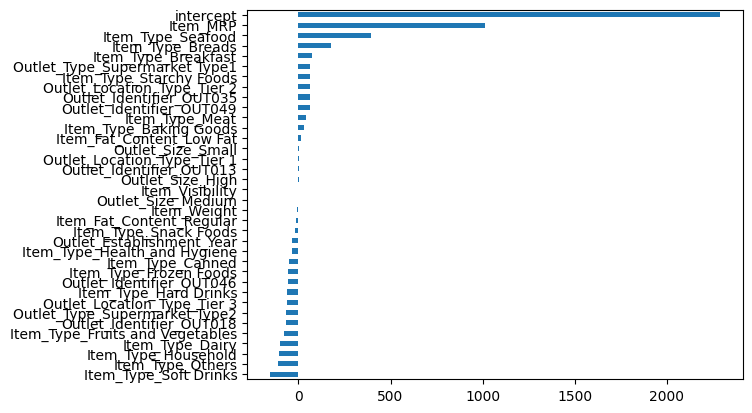

In [42]:
## Create a barplot of the coefficients
## sorted by values
coef_series.sort_values().plot(kind='barh');

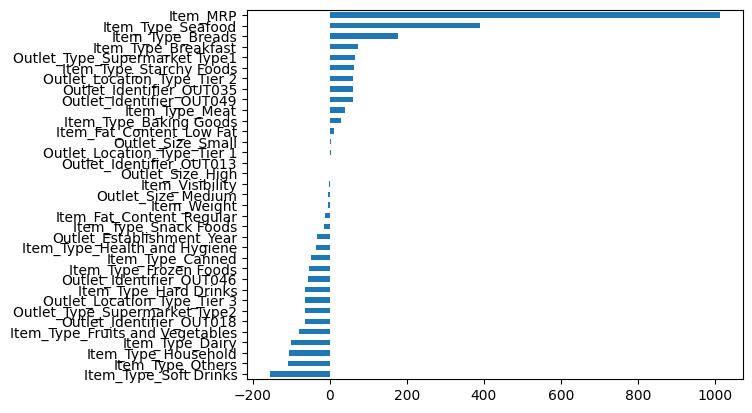

In [43]:
## Create a barplot of the coefficients
## sorted by values
## and drop the intercept
coef_series.drop('intercept').sort_values().plot(kind='barh');

2. The second task is to build a Random Forest model to predict sales

Build a default Random Forest model

Use the customer evaluation function to get the metrics for your model(on training and test data).

Compare the training and test R-squared values and answer the question: to what extent is the model overfit/underfit?

Compare this model's performance to the linear regression model: which model has the best scores?

In [44]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state = 42)
# Model Pipeline
rf_pipe = make_pipeline(preprocessor, rf)

In [45]:
# Fit the model pipeline on the training data only
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('Numeric', StandardScaler(),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('Categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [46]:
# Use custom function to evaluate default model
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 319.483
- MSE = 191,791.331
- RMSE = 437.940
- R^2 = 0.915

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 839.245
- MSE = 1,297,875.432
- RMSE = 1,139.243
- R^2 = 0.416


Using the Random Forest, it shows that the data is overfitted, as the training data is 0.92 and the testing data is only 0.42. It also shows low variance, as the model performed worse on the testing data.

Use GridSearchCV to tune at least two hyperparameters for a Random Forest model.
After determining the best parameters from your GridSearch, fit and evaluate a final best model on the entire training set (no folds). Compare your tuned model to your default Random Forest: did the performance improve?

In [47]:
# Parameters for tuning
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('Numeric', StandardScaler(),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('Categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
          'Outlet_Location_Type', 'Outlet_Type'],
         dtype='object'))],
                     verbose_feature_names_out=False)),
  ('randomforestregressor', RandomForestRegressor(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('Numeric', StandardScaler(),
                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establish

In [48]:
# Define param grid with options to try
params = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None],
          'randomforestregressor__oob_score':[True,False],
          }

In [49]:
# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv = 3, verbose=1)
# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('Numeric',
                                                                         StandardScaler(),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                                        ('Categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifie...
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 10, 15, 20],
                         'randomforestregressor__max_features': ['sqrt', 'log2',
                                                                 None],
                         'randomforestregressor__min_samples_leaf': [2, 3, 4],
                         'randomforestregressor__n_estimators': [10, 100, 150,
                                                                 200],
                         'randomforestregressor__oob_score': [True, False]},
             verbose=1)

In [50]:
# Obtain best parameters
gridsearch.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': None,
 'randomforestregressor__min_samples_leaf': 4,
 'randomforestregressor__n_estimators': 100,
 'randomforestregressor__oob_score': True}

In [51]:
# Define and refit best model
best_rf = gridsearch.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)


------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 641.142
- MSE = 769,807.812
- RMSE = 877.387
- R^2 = 0.658

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 808.031
- MSE = 1,185,592.122
- RMSE = 1,088.849
- R^2 = 0.466


Using Decision Tree Regressor

In [52]:
# Instantiate a default model with random state for reproducibility
model = DecisionTreeRegressor(random_state = 42)
# Fit the default model on the training data
model.fit(X_train_tf, y_train)
# Use custom function to predict and evaluate
evaluate_regression(model, X_train_tf, y_train, X_test_tf, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 0.000
- MSE = 0.000
- RMSE = 0.000
- R^2 = 1.000

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 1,199.366
- MSE = 2,782,919.015
- RMSE = 1,668.208
- R^2 = -0.253


Using GridSearch CV, the data shows that the training data performed better than the test data, which is similar to what the Random Forest model.

You now have tried several different models on your data set. You need to determine which model to implement.

Overall, which model do you recommend? Justify your recommendation. In a Markdown cell: Interpret your model's performance based on R-squared in plain English. Select another regression metric (RMSE/MAE/MSE) to express the performance of your model to your stakeholder in a way that is relevant to the original business problem (predicting sales). Include why you selected this metric to explain to your stakeholder. Compare the training vs. test scores and answer the question: to what extent is this model overfit/underfit?

Based upon the data of the R-squared, I would choose Random Forest over Linear Regression. The Random Forest Model showed better results on the training data than the Linear Regression Model.
Random Forest Models are powerful and they have numerous hyperparameters to improve their performance. When we used GridSearch CV, the data showed the training data was similar to the Random Forest Model, which indicates that when it is tuned, data works similar.

Based upon the data, we can determine that grocery store sales performed better with the Random Forest Model and this model is better at predicting sales than the Linear Regression on the R-squared model.

On the other hand, if we look at Root Mean Squared Error(RMSE), performed worse on the training data, which was 1,142 and it performed better on the test data, which was 1,090 on the Linear Regression Model. However, the Linear Regression model does show that the data is similar on both test and train models.

For the Random Forest Model, RMSE performed better on the training data, which was 427.73 for the training. The test data for Random Forest did worse on the test, which was 1,104. We can assume that the Random Forest Model performed better on the training data but poorly on the test data due to overfitting.

Based upon RMSE, we can assume that the RMSE would be better on the training data using the Random Forest Model and the Linear Regression Model would be better on the test data.

Based upon Linear and Random Forest Regression, I would say that the Linear Regression Model would better predict sales because the Random Forest is higher in variance and Linear Regression model is more balanced at predicting sales.

Extract and visualize the feature Importance

In [53]:
# Extract Feature Importances
importances = rf.feature_importances_
importances

array([0.09488717, 0.12828176, 0.5936693 , 0.01598065, 0.00688632,
       0.00692917, 0.00637426, 0.00365969, 0.00323931, 0.00559515,
       0.00635598, 0.00780461, 0.01009518, 0.00300353, 0.00688126,
       0.00807613, 0.00535397, 0.00207716, 0.00231097, 0.01157372,
       0.00537877, 0.00404106, 0.00304672, 0.00299923, 0.00469564,
       0.00755069, 0.00505561, 0.00348769, 0.00459755, 0.00685582,
       0.00604155, 0.00452963, 0.00608505, 0.00401705, 0.00258263])

In [54]:
## Define a function to extract importances from a model
def get_feature_importances(model):
    importances = model.feature_importances_
    feature_names = model.feature_names_in_
    return pd.Series(importances, index=feature_names)

In [55]:
## Define a series variable by
## calling the get_feature_importances function
## to obtain importances from a model
importances =  get_feature_importances(rf)
importances

Item_Weight                       0.0949
Item_Visibility                   0.1283
Item_MRP                          0.5937
Outlet_Establishment_Year         0.0160
Item_Fat_Content_Low Fat          0.0069
Item_Fat_Content_Regular          0.0069
Item_Type_Baking Goods            0.0064
Item_Type_Breads                  0.0037
Item_Type_Breakfast               0.0032
Item_Type_Canned                  0.0056
Item_Type_Dairy                   0.0064
Item_Type_Frozen Foods            0.0078
Item_Type_Fruits and Vegetables   0.0101
Item_Type_Hard Drinks             0.0030
Item_Type_Health and Hygiene      0.0069
Item_Type_Household               0.0081
Item_Type_Meat                    0.0054
Item_Type_Others                  0.0021
Item_Type_Seafood                 0.0023
Item_Type_Snack Foods             0.0116
Item_Type_Soft Drinks             0.0054
Item_Type_Starchy Foods           0.0040
Outlet_Identifier_OUT013          0.0030
Outlet_Identifier_OUT018          0.0030
Outlet_Identifie

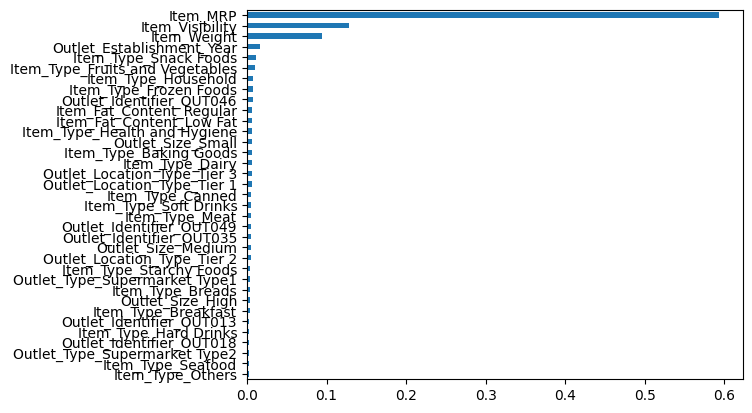

In [56]:
## Create a barplot of the importance series variable
## sorted by values
importances.sort_values().plot(kind='barh');